<a href="https://colab.research.google.com/github/SonamKul9527/Melanoma_Detection_Assignment/blob/main/sonam_k_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

We will build a multiclass classification model using a custom convolutional neural network in TensorFlow

In [1]:
## Mount Google Drive to load the data from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Unzipping the data from specified drive folder

!unzip -q "/content/gdrive/My Drive/CNN_assignment.zip" -d "/content/gdrive/My Drive/CNN_assignment"

replace /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
## Importing Required Libraries

import os
import PIL
import pathlib 
import Augmentor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
## Defining the path for Train and Test images directories

data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
## Count the number of images in Train and Test Directories. Using the glob to retrieve files/pathnames matching a specified pattern.

## Train Image Count
img_train_cnt = len(list(data_dir_train.glob('*/*.jpg')))
print(img_train_cnt)

## Test Image Count
img_test_cnt = len(list(data_dir_test.glob('*/*.jpg')))
print(img_test_cnt)

2238
118


### Data Visualization

Code to visualize one instance of all the nine classes present in the dataset

In [6]:
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

Found 15738 files belonging to 9 classes.


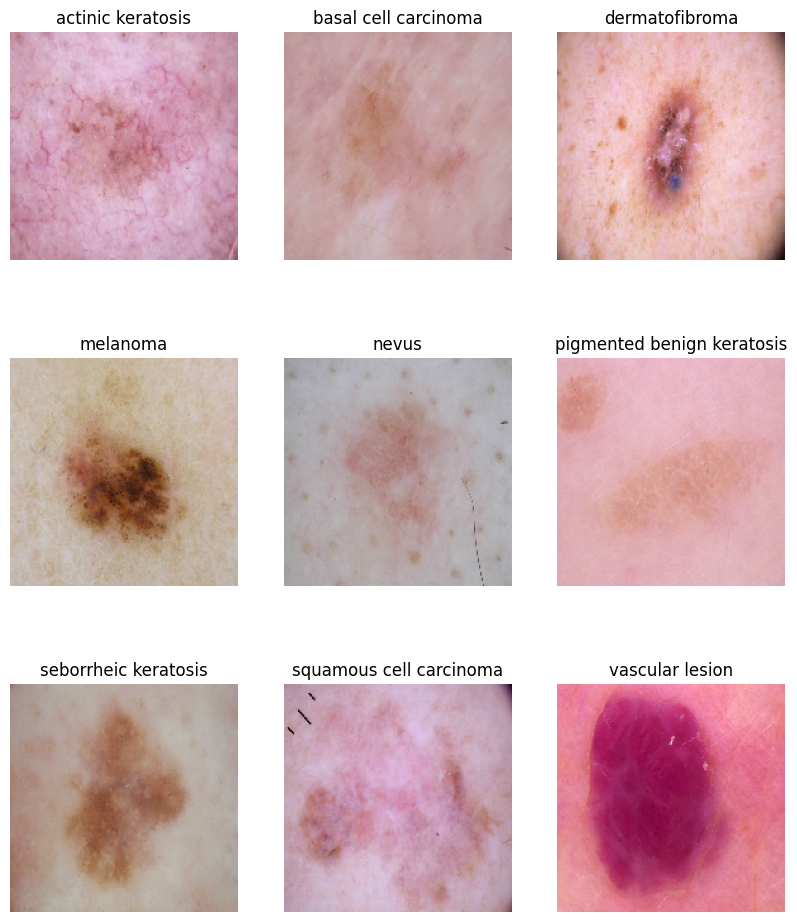

In [7]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(10,12))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

#### Counting the number of classes in each directory to check and evaluate Class Embalance

In [8]:
def each_cls_count(data_dir): 

  ## Counting the number of image in each class directory
  count = []
  for path in pathlib.Path(data_dir).iterdir() :
    if path.is_dir() :
       count.append(len([img_in_dir for img_in_dir in os.listdir(path)
                               if os.path.isfile(os.path.join(path, img_in_dir))]))
  ## Name of the classes
  sub_directory = [img_in_dir for img_in_dir in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, img_in_dir))]    

  ## Return the dataframe with image count and class.
  return pd.DataFrame(list(zip(sub_directory,count)), columns =['Class', 'No. of Image'])

In [9]:
class_data = each_cls_count(data_dir_train)
class_data

,Class,No. of Image
0,actinic keratosis,113
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Figure size 1200x1500 with 0 Axes>

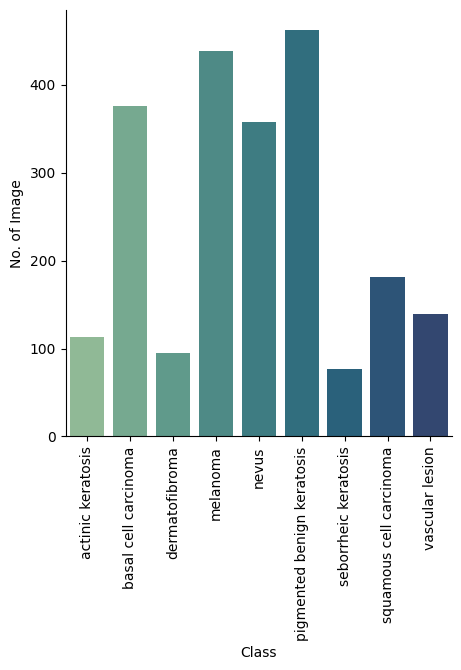

In [10]:
plt.figure(figsize=(12, 15))
sns.catplot(x="Class", y= "No. of Image", data = class_data, kind="bar", palette="crest")
plt.xticks(rotation = 90)
plt.show()

From the above plot, we can clearly observe Class Imbalance in the training data. We need to handle it using the Augmentor Library

## Model Building

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180
input_size = (img_width, img_height, 3)

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size = batch_size, seed = 123, image_size = (img_height, img_width),
    validation_split=0.2, subset='training',  label_mode='categorical'
    )

Found 15738 files belonging to 9 classes.
Using 12591 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size = batch_size, seed = 123, image_size = (img_height, img_width),
    validation_split=0.2, subset='validation', label_mode='categorical'
)

Found 15738 files belonging to 9 classes.
Using 3147 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. 
* We will be building the model, rescaling the images to normalize pixel values between (0,1).

In [16]:
num_of_classes = len(class_names)
print(num_of_classes)

9


In [21]:
model = Sequential()

## Rescaling the data
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape= input_size))

## First Convulation Layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Second Convulation Layer
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Third Convolution 
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and put a fully connected Dense layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(num_of_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 172, 172, 64)      51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 86, 86, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 82, 82, 64)        102464    
                                                                 
 conv2d_8 (Conv2D)           (None, 78, 78, 32)        51232     
                                                      

### Compile the model

Choose an appropirate optimiser and loss function for model training

In [22]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

### Train the model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 64s 141ms/step - loss: 1.7312 - accuracy: 0.3258 - val_loss: 1.4169 - val_accuracy: 0.4490
Epoch 2/20
394/394 [==============================] - 52s 132ms/step - loss: 1.3974 - accuracy: 0.4719 - val_loss: 1.2219 - val_accuracy: 0.5297
Epoch 3/20
394/394 [==============================] - 52s 131ms/step - loss: 1.1556 - accuracy: 0.5709 - val_loss: 0.9647 - val_accuracy: 0.6482
Epoch 4/20
394/394 [==============================] - 52s 131ms/step - loss: 0.9623 - accuracy: 0.6456 - val_loss: 0.9621 - val_accuracy: 0.6629
Epoch 5/20
394/394 [==============================] - 54s 137ms/step - loss: 0.8362 - accuracy: 0.6949 - val_loss: 0.8996 - val_accuracy: 0.6905
Epoch 6/20
394/394 [==============================] - 52s 131ms/step - loss: 0.7494 - accuracy: 0.7308 - val_loss: 0.7305 - val_accuracy: 0.7569
Epoch 7/20
394/394 [==============================] - 52s 131ms/step - loss: 0.6617 - accuracy: 0.7626 - val_loss: 0.6424 - val_ac

### Visualizing training results

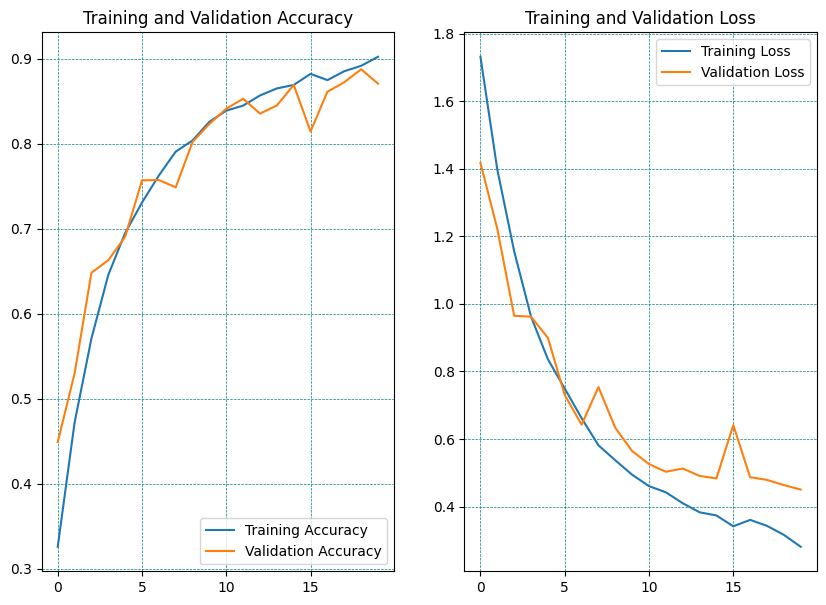

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
plt.show()

### Model Findings 

*   Model Overfitting : We can clearly observe from the above plot, the model seems to overfit as there patterns are almost similar to the train dataset.
*   Model has learned the patterns which are distict towards the last 5 to 10 epochs. This we can handle by adding more layers or tune the parameters or Data Augmentation.
*   Accuracy is around 90% whereas the validation accuracy is around 87%.

### Data Augmentation

In [ ]:
training_dataset_path = "/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for i in class_names :
  pipeline = Augmentor.Pipeline(training_dataset_path + i)
  pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

  ## Adding 500 samples per class to make sure that none of the classes are sparse
  pipeline.sample(500)

In [ ]:
## Counting total number of image generated by Augmentor

image_count_augmentor = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_augmentor)

### Class distribution: 


*   Least Number of Samples : Seborrheic keratosis class has the least number
*   Highest Number of Samples : Pigmented benign keratosis class is the dominating class as per the training data	



## Model Building using Augmented Data 

In [ ]:
model = Sequential()

## Rescaling the data
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape= input_size))

## First Convulation Layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Second Convulation Layer
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

## Third Convolution 
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and put a fully connected Dense layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(num_of_classes, activation='softmax'))

model.summary()